*   Nama : Ilham Oktavian
*   Dataset : train-ML-Sub2.csv
*   Sumber : Kaggle
*   Link Dataset : https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# Library
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [41]:
# Tentukan jalur file CSV
file_path = './drive/MyDrive/Dataset/train_ML_Sub2.csv'

# Baca file CSV ke dalam DataFrame
df = pd.read_csv(file_path)

# Tampilkan lima baris pertama dari DataFrame
df.head()

,Datetime,EKPC_MW
0,2013-12-31 01:00:00,1861.0
1,2013-12-31 02:00:00,1835.0
2,2013-12-31 03:00:00,1841.0
3,2013-12-31 04:00:00,1872.0
4,2013-12-31 05:00:00,1934.0


In [42]:
# Menampilkan jumlah baris dalam DataFrame
num_rows = len(df)
num_rows

45334

In [43]:
# Menampilkan informasi ringkas tentang DataFrame
df_info = df.info()
df_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45334 entries, 0 to 45333
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  45334 non-null  object 
 1   EKPC_MW   45334 non-null  float64
dtypes: float64(1), object(1)
memory usage: 708.5+ KB


In [44]:
# Menghitung jumlah nilai null dalam setiap kolom DataFrame
null_counts = df.isnull().sum()
null_counts


Datetime    0
EKPC_MW     0
dtype: int64

In [45]:
# Mengambil nilai dari kolom 'Datetime' dan 'EKPC_MW' dalam bentuk array
dates = df['Datetime'].values
EKPC_NW = df['EKPC_MW'].values

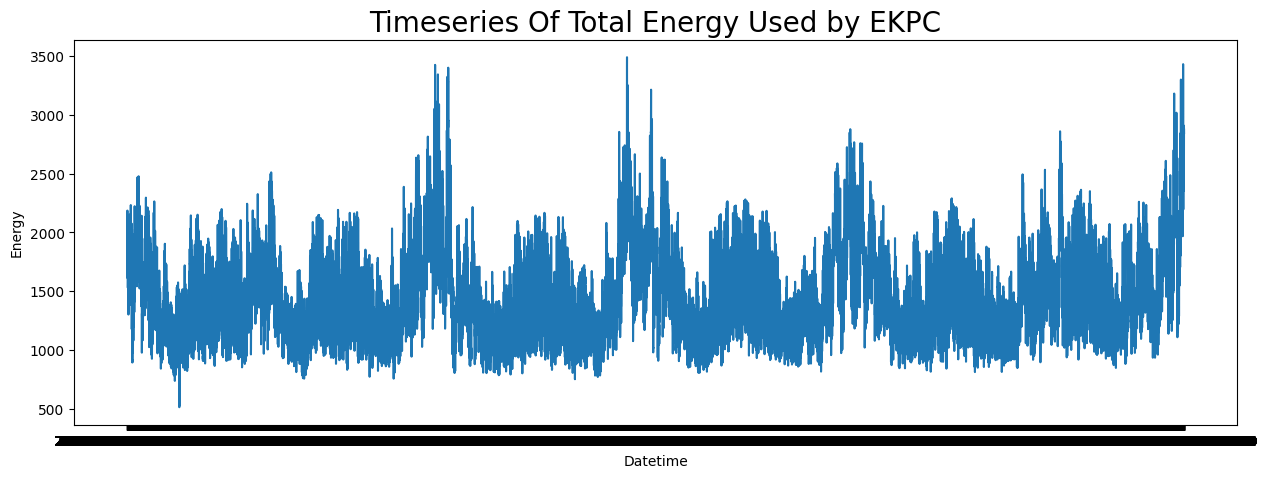

In [46]:
# Mengatur ukuran gambar plot
plt.figure(figsize=(15, 5))

# Membuat plot time series menggunakan data 'dates' dan 'EKPC_NW'
plt.plot(dates, EKPC_NW)

# Menambahkan judul plot
plt.title('Timeseries Of Total Energy Used by EKPC', fontsize=20)

# Menambahkan label sumbu x dan y
plt.xlabel('Datetime')
plt.ylabel('Energy')

# Menampilkan plot
plt.show()

In [47]:
# Mengonversi kolom 'Datetime' ke tipe data datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Menampilkan informasi ringkas tentang DataFrame setelah perubahan
df_info_after_conversion = df.info()
df_info_after_conversion

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45334 entries, 0 to 45333
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  45334 non-null  datetime64[ns]
 1   EKPC_MW   45334 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 708.5 KB


In [48]:
# Mengubah bentuk array 'EKPC_NW' menjadi matriks satu kolom
EKPC_NW = EKPC_NW.reshape(-1, 1)

# Menampilkan array setelah perubahan bentuk
EKPC_NW

array([[1861.],
       [1835.],
       [1841.],
       ...,
       [2883.],
       [2880.],
       [2846.]])

In [49]:
# Inisialisasi objek MinMaxScaler
scaler = MinMaxScaler()

# Menggunakan MinMaxScaler untuk melakukan penskalaan Min-Max pada 'EKPC_NW'
EKPC_NW_scaled = scaler.fit_transform(EKPC_NW)

# Menampilkan hasil penskalaan
EKPC_NW_scaled

array([[0.45262097],
       [0.44388441],
       [0.44590054],
       ...,
       [0.79603495],
       [0.79502688],
       [0.78360215]])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(EKPC_NW, dates, test_size=0.2, shuffle=False)

In [51]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Menambahkan dimensi tambahan pada series (asumsi series adalah satu dimensi)
    series = tf.expand_dims(series, axis=-1)

    # Membuat dataset dari tensor series
    ds = tf.data.Dataset.from_tensor_slices(series)

    # Membuat jendela geser pada dataset
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)

    # Membuat batch dari jendela geser
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))

    # Mengacak urutan data dalam dataset
    ds = ds.shuffle(shuffle_buffer)

    # Memisahkan setiap jendela menjadi fitur dan label
    ds = ds.map(lambda w: (w[:-1], w[-1:]))

    # Membagi dataset menjadi batch dengan ukuran tertentu dan melakukan prefetching
    return ds.batch(batch_size).prefetch(1)

In [52]:
# Membuat dataset pelatihan dan pengujian menggunakan fungsi windowed_dataset
train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set  = windowed_dataset(X_test, window_size=60, batch_size=32, shuffle_buffer=1000)

# Membuat model sequential dengan layer LSTM dan Dense
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [53]:
# Menghitung rentang data EKPC_NW
data_range = EKPC_NW.max() - EKPC_NW.min()

# Menghitung batas maksimal nilai MAE (10%) dari rentang data
threshold_mae = data_range * 10 / 100

# Menampilkan hasil
print("Batas maksimal nilai MAE (10%) dari data adalah sebesar", threshold_mae)

Batas maksimal nilai MAE (10%) dari data adalah sebesar 297.6


In [54]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Mendapatkan nilai MAE dan val_mae dari logs
        current_mae = logs.get('mae')
        current_val_mae = logs.get('val_mae')

        # Mengecek apakah keduanya berada di bawah threshold
        if current_mae is not None and current_val_mae is not None:
            if current_mae < threshold_mae and current_val_mae < threshold_mae:
                print("MAE < 10%, pelatihan dihentikan.")
                self.model.stop_training = True

# Membuat objek callback
callbacks = myCallback()


In [55]:
# Menggunakan Stochastic Gradient Descent (SGD) sebagai optimizer dengan learning rate dan momentum tertentu
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

# Mengompilasi model dengan Huber loss, SGD optimizer, dan mae sebagai metrik
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Melatih model dengan data pelatihan dan evaluasi pada data validasi
# Callback callbacks=myCallback() digunakan untuk menghentikan pelatihan jika MAE < 10%
hist = model.fit(train_set,
                 epochs=50,
                 validation_data=test_set,
                 verbose=2,
                 callbacks=[callbacks])


Epoch 1/50
363/363 - 60s - loss: 1452.2437 - mae: 1452.6986 - val_loss: 1487.6720 - val_mae: 1487.8427 - 60s/epoch - 166ms/step
Epoch 2/50
363/363 - 55s - loss: 686.2137 - mae: 686.8121 - val_loss: 293.2524 - val_mae: 293.4249 - 55s/epoch - 153ms/step
Epoch 3/50
MAE < 10%, pelatihan dihentikan.
363/363 - 57s - loss: 289.3775 - mae: 289.8850 - val_loss: 291.0249 - val_mae: 291.3971 - 57s/epoch - 158ms/step


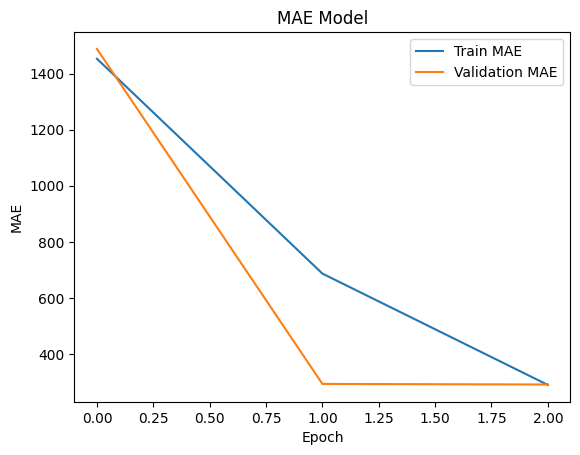

In [56]:
# Plot MAE (Mean Absolute Error) pada set pelatihan dan set validasi

# Menampilkan nilai MAE pada set pelatihan
plt.plot(hist.history['mae'], label='Train MAE')

# Menampilkan nilai MAE pada set validasi
plt.plot(hist.history['val_mae'], label='Validation MAE')

# Menambahkan judul dan label pada sumbu
plt.title('MAE Model')
plt.ylabel('MAE')
plt.xlabel('Epoch')

# Menambahkan legenda untuk membedakan antara set pelatihan dan set validasi
plt.legend(loc='upper right')

# Menampilkan plot
plt.show()


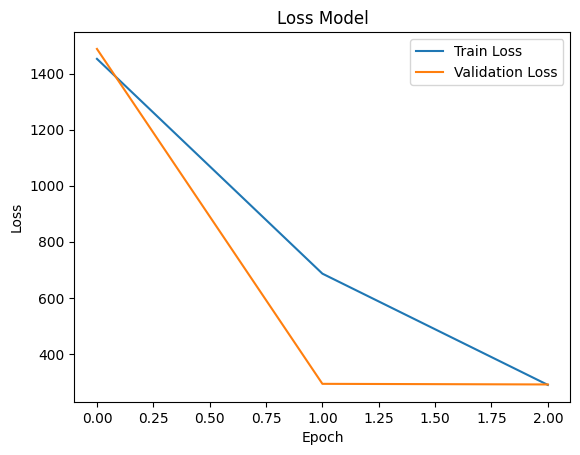

In [57]:
# Plot Loss pada set pelatihan dan set validasi

# Menampilkan nilai loss pada set pelatihan
plt.plot(hist.history['loss'], label='Train Loss')

# Menampilkan nilai loss pada set validasi
plt.plot(hist.history['val_loss'], label='Validation Loss')

# Menambahkan judul dan label pada sumbu
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Menambahkan legenda untuk membedakan antara set pelatihan dan set validasi
plt.legend(loc='upper right')

# Menampilkan plot
plt.show()
